#### Conjunto de Datos

In [1]:
import os

# directorios del conjuntos de datos (palmas y máscaras)
img_dir = "/Datasets/5k-palms/40k-jpg-256x256/"
label_dir = "/Datasets/5k-palms/40k-masks-mono-256x256/"

# leemos el conjunto de datos de la lista de todos los archivos
img_files = [img_dir + f for f in os.listdir(img_dir)]
label_files = [label_dir + f for f in os.listdir(label_dir)]
# la lista devuelta por listdir está en orden aleatorio
img_files.sort()
label_files.sort()

In [2]:
from sklearn.model_selection import train_test_split

# generamos el conjunto de datos de prueba, el de validación y el de entrenamiento
x_test_filenames, img_files_after_test, y_test_filenames, label_files_after_test = \
        train_test_split(img_files, label_files, test_size=0.1, random_state=42)

x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
        train_test_split(img_files_after_test, label_files_after_test, test_size=0.2, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 3448
Number of validation examples: 863


In [3]:
print(x_train_filenames[:1], y_train_filenames[:1])

['/Datasets/5k-palms/40k-jpg-256x256/Hand_0009039.jpg.2.jpg'] ['/Datasets/5k-palms/40k-masks-mono-256x256/Hand_0009039.jpg.2.png']


#### Dataset en TF

In [4]:
import _40k_dataset
import importlib
importlib.reload(_40k_dataset)  # hot-reload
from _40k_dataset import _augment, get_baseline_dataset

import functools

# definición de constantes 
img_shape = (256, 256, 1)  # debe ser divisible por 32 (maxpool2d)
batch_size = 8

# construcción de dataset
tr_cfg = {
    # 'resize': [img_shape[0], img_shape[1]],  # dataset ya tiene tamaño de entrada del modelo
    'togray': True,
    'scale': 1 / 255.
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)

val_cfg = {
    # 'resize': [img_shape[0], img_shape[1]],  # dataset ya tiene tamaño de entrada del modelo
    'togray': True,
    'scale': 1 / 255.
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

#### Construyendo el modelo
A partir del modelo propuesto en https://arxiv.org/abs/1505.04597, modelo codificador-decodificador.

In [5]:
import _40k_model
import importlib
importlib.reload(_40k_model)  # hot-reload
from _40k_model import encoder_block, decoder_block, conv_block, bce_dice_loss, dice_loss

from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from tensorflow.python.keras import losses

inputs = layers.Input(shape=img_shape)
# 256
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8
center = conv_block(encoder4_pool, 1024)
# center
decoder4 = decoder_block(center, encoder4, 512)
# 16
decoder3 = decoder_block(decoder4, encoder3, 256)
# 32
decoder2 = decoder_block(decoder3, encoder2, 128)
# 64
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 256
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

model = models.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

#### Métricas de pérdida 
- Dice loss: measures overlap http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf
- Binary cross entropy 

### 100 epochs with 3.5k images

In [6]:
import tensorflow as tf
import numpy as np

epochs = 72
save_model_path = '/Datasets/5k-palms/40k-weights-100ep-3.5k-gray.hdf5'

cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [7]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

Epoch 1/72
431/431 [==============================] - 281s 651ms/step - loss: 0.5670 - dice_loss: 0.2519 - val_loss: 1.1473 - val_dice_loss: 0.3385

Epoch 00001: val_dice_loss improved from inf to 0.33854, saving model to /Datasets/5k-palms/40k-weights-100ep-3.5k-gray.hdf5
Epoch 2/72
431/431 [==============================] - 270s 626ms/step - loss: 0.3140 - dice_loss: 0.1352 - val_loss: 0.6392 - val_dice_loss: 0.2178

Epoch 00002: val_dice_loss improved from 0.33854 to 0.21780, saving model to /Datasets/5k-palms/40k-weights-100ep-3.5k-gray.hdf5
Epoch 3/72
431/431 [==============================] - 270s 626ms/step - loss: 0.1893 - dice_loss: 0.0800 - val_loss: 1.6571 - val_dice_loss: 0.4887

Epoch 00003: val_dice_loss did not improve from 0.21780
Epoch 4/72
431/431 [==============================] - 270s 626ms/step - loss: 0.1515 - dice_loss: 0.0626 - val_loss: 0.1094 - val_dice_loss: 0.0494

Epoch 00004: val_dice_loss improved from 0.21780 to 0.04939, saving model to /Datasets/5k-palm

431/431 [==============================] - 270s 626ms/step - loss: 0.0515 - dice_loss: 0.0213 - val_loss: 0.0446 - val_dice_loss: 0.0185

Epoch 00036: val_dice_loss did not improve from 0.01495
Epoch 37/72
431/431 [==============================] - 270s 626ms/step - loss: 0.0352 - dice_loss: 0.0154 - val_loss: 0.0384 - val_dice_loss: 0.0162

Epoch 00037: val_dice_loss did not improve from 0.01495
Epoch 38/72
431/431 [==============================] - 270s 626ms/step - loss: 0.0310 - dice_loss: 0.0137 - val_loss: 0.0385 - val_dice_loss: 0.0156

Epoch 00038: val_dice_loss did not improve from 0.01495
Epoch 39/72
431/431 [==============================] - 270s 626ms/step - loss: 0.0299 - dice_loss: 0.0133 - val_loss: 0.0376 - val_dice_loss: 0.0152

Epoch 00039: val_dice_loss did not improve from 0.01495
Epoch 40/72
431/431 [==============================] - 270s 626ms/step - loss: 0.0293 - dice_loss: 0.0131 - val_loss: 0.0379 - val_dice_loss: 0.0150

Epoch 00040: val_dice_loss did not imp

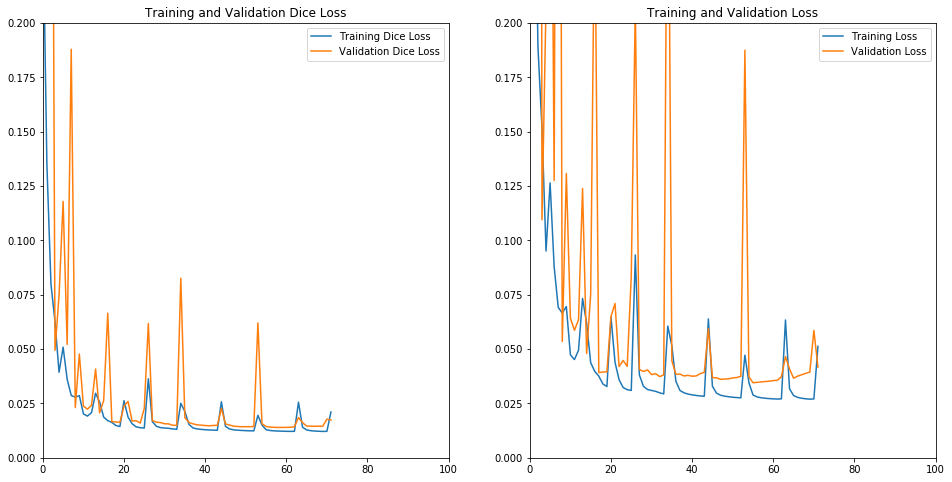

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

dice = history.history['dice_loss'][:]
val_dice = history.history['val_dice_loss'][:]

loss = history.history['loss'][:]
val_loss = history.history['val_loss'][:]

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')
plt.ylim((0,0.2))
plt.xlim((0,100))

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim((0,0.2))
plt.xlim((0,100))

plt.show()

In [9]:
save_model_path = '/Datasets/5k-palms/40k-weights-100ep-3.5k-gray'
model.save_weights(save_model_path)
model.save(save_model_path + '.h5')
print(save_model_path + " saved")

/Datasets/5k-palms/40k-weights-100ep-3.5k-gray saved
